In [1]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Preparation

In [2]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


def download_cifar10_data():
    train_dataset = datasets.CIFAR10( root='./data', train=True, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
    return train_dataset, test_dataset



def prepare_cifar10_data(transform, batch_size=64, val_split=0.2):

    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

    train_size = int((1 - val_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
download_cifar10_data()

100%|██████████| 170M/170M [00:11<00:00, 15.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train,
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

### Autoencoder

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
def train_model(model, optimizer, num_epochs=25, device='cpu'):
    best_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0

            # Iterate over data.
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = ((outputs - inputs) ** 2).mean()  # For autoencoder, compare outputs with inputs

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                # Save the best model checkpoint
                torch.save(model.state_dict(), 'best_model.pth')
    # load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model

In [16]:
def test_and_visualize(model, test_loader, device='cpu', n_visualize=5):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0

    # Calculate the test loss
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = ((outputs - inputs) ** 2).mean()
            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Visualization
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images.to(device)

    with torch.no_grad():
        reconstructed = model(images)

    images = images.cpu()
    reconstructed = reconstructed.cpu()

    plt.figure(figsize=(10, 4.5))
    for i in range(n_visualize):
        # Original images
        ax = plt.subplot(2, n_visualize, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n_visualize, i + 1 + n_visualize)
        plt.imshow(reconstructed[i].permute(1, 2, 0))
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

    return test_loss

Epoch 1/20
train Loss: 1.0733
val Loss: 0.9726
Epoch 2/20
train Loss: 0.9610
val Loss: 0.9468
Epoch 3/20
train Loss: 0.9458
val Loss: 0.9379
Epoch 4/20
train Loss: 0.9391
val Loss: 0.9327
Epoch 5/20
train Loss: 0.9341
val Loss: 0.9288
Epoch 6/20
train Loss: 0.9317
val Loss: 0.9266
Epoch 7/20
train Loss: 0.9300
val Loss: 0.9255
Epoch 8/20
train Loss: 0.9289
val Loss: 0.9243
Epoch 9/20
train Loss: 0.9279
val Loss: 0.9235
Epoch 10/20
train Loss: 0.9270
val Loss: 0.9222
Epoch 11/20
train Loss: 0.9258
val Loss: 0.9213
Epoch 12/20
train Loss: 0.9252
val Loss: 0.9207
Epoch 13/20
train Loss: 0.9246
val Loss: 0.9204
Epoch 14/20
train Loss: 0.9240
val Loss: 0.9198
Epoch 15/20
train Loss: 0.9233
val Loss: 0.9198
Epoch 16/20
train Loss: 0.9226
val Loss: 0.9184
Epoch 17/20
train Loss: 0.9221
val Loss: 0.9181
Epoch 18/20
train Loss: 0.9216
val Loss: 0.9177
Epoch 19/20
train Loss: 0.9213
val Loss: 0.9171
Epoch 20/20
train Loss: 0.9209
val Loss: 0.9167


Test Loss: 0.9059


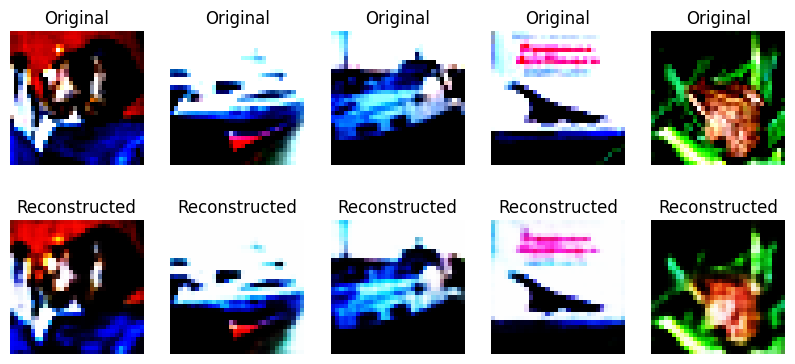

In [17]:
batch_size = 64
learning_rate = 1e-3
num_epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

train_loader, val_loader, test_loader = prepare_cifar10_data(transform, batch_size)

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(model, optimizer, num_epochs=num_epochs, device=device)

test_loss = test_and_visualize(model, test_loader, device, n_visualize=5)